# Analysis of General Public graphs





In [39]:
import warnings
warnings.filterwarnings("ignore")
import glob
import os
import os.path as op
import sys
sys.path.append(
    '/Users/CN/Documents/Projects/Cambridge/cambridge_language_analysis/')

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Data Processing
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import re
# import gensim
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import networkx as nx


In [40]:
# SemanticSpeechGraph functions
from compile_graphs_dataset import get_graphs, graph_properties, exclude_empty_graphs
from graph_analysis_functions import print_bidirectional_edges, print_parallel_edges, get_parallel_edges
from word_embedding_analysis import central_words

In [41]:
# --------------------- Import graphs ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/all_tats'
output_figures = op.join(graph_dir, 'figures')

graphs, filelist = get_graphs(graph_dir)
graphs, filelist = exclude_empty_graphs(graphs, filelist, be_quiet=True)



Obtained 2861 graphs. Excluded 16 empty graphs. Kept 2845 graphs.


In [42]:
# --------------------- Import graph data ---------------------------------------
df = pd.read_csv(op.join(graph_dir, 'output/graph_data_normalised.csv'))

print('Described {0} graphs.\n{1} subjects described {2} ± {3} pictures.'.format(df.shape[0], len(df.subj.unique()), round(df.subj.value_counts().mean(),2), round(df.subj.value_counts().std(),2)))

# Make subj and tat categorical
df.subj = pd.Categorical(df.subj.astype('str'))
df.tat = pd.Categorical(df.tat.astype('str'))
df.tat = df.tat.cat.rename_categories({'8': '08'})
df.tat = df.tat.cat.reorder_categories(
    ['08', '10', '13', '19', '21', '24', '28', '30'])

Described 2845 graphs.
436 subjects described 6.53 ± 2.39 pictures.


# Control for network size in Oasis data
1. Estimate relationship between number of nodes and connected component measures general public data
2. Regress association out of Oasis data

In [43]:

# --------------------- Import OASIS data ---------------------------------------
graph_dir = '/Users/CN/Dropbox/speech_graphs/oasis'
oasis = pd.read_csv(op.join(graph_dir, 'output/graph_data_normalised.csv'))
oasis['group'] = pd.Categorical(oasis.group)
oasis.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'], inplace=True)




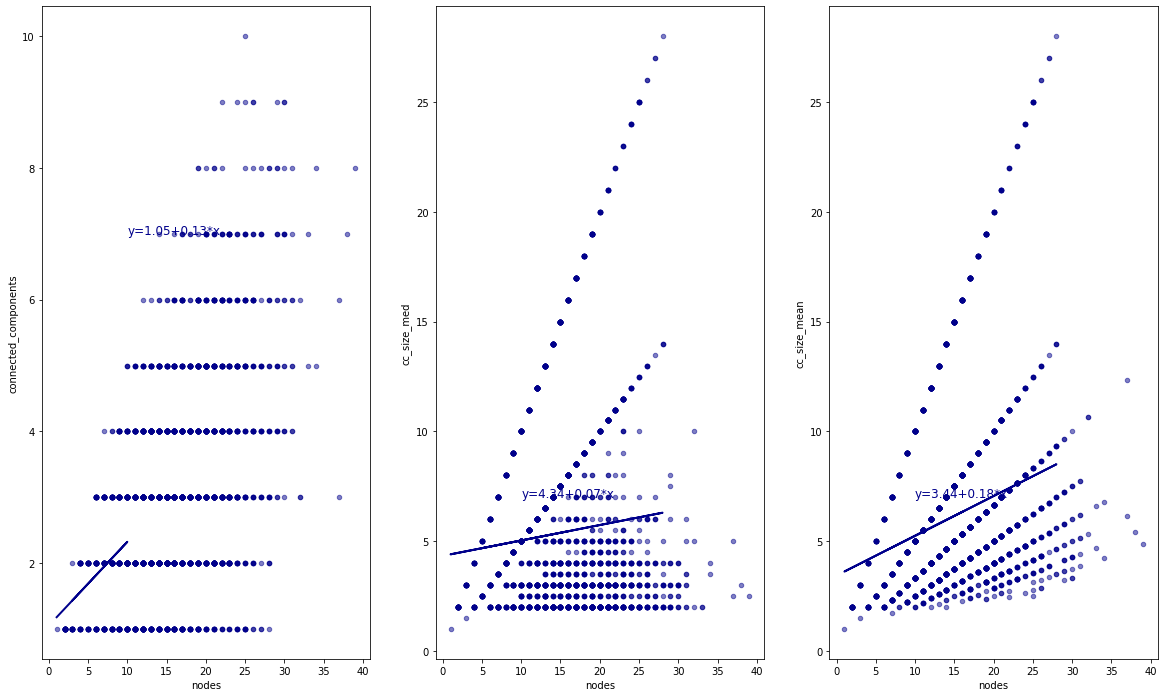

In [44]:
# Estimate relationship in general public data
nans = np.isnan(df.cc_size_med.values)
df_nonan = df[~nans]
variables = ['connected_components', 'cc_size_med', 'cc_size_mean']

fig = plt.figure(figsize=(20, 12))
for v,plot_variable in enumerate(variables):
    # best fit polynomial
    node_fit = np.polyfit(df_nonan.nodes, df_nonan[plot_variable], 1)
    # Predict values for Oasis
    pred_vals = np.polyval(node_fit, oasis.nodes)
    # Calculate residuals
    residuals = oasis.connected_components_normZ - pred_vals
    # Add residuals to dataframe
    oasis[plot_variable + '_res'] = residuals
    # scatter plot
    ax = plt.subplot(1,3,v+1)
    df_nonan.plot(kind='scatter', x='nodes', y=plot_variable, color='darkblue', alpha=0.5, ax = ax)
    # regression lines
    plt.plot(df_nonan[plot_variable], node_fit[0] * df_nonan[plot_variable] + node_fit[1], color='darkblue', linewidth=2)
    # regression equations
    plt.text(10, 7, 'y={:.2f}+{:.2f}*x'.format(node_fit[1], node_fit[0]), color='darkblue', size=12)




In [62]:
# --------------------- Write residualised variables to csv ---------------------------------------

oasis[['subj', 'words', 'sentences', 'nodes', 'connected_components_res', 'cc_size_med_res', 'cc_size_mean_res']].to_csv(op.join('/Users/CN/Dropbox/speech_graphs/oasis/output', 'graph_data_residualised.csv'))
# oasis.to_csv(op.join('/Users/CN/Dropbox/speech_graphs/oasis/output', 'graph_data_residualised_avg.csv'))


# --------------------- Average across tats ---------------------------------------
oasis_avg = (oasis.groupby((oasis.subj != oasis.subj.shift()).cumsum())
          .mean()
          .reset_index(drop=True))

# Add subj index that was dropped during averaging back into dataframe
oasis_avg['subj'] = None
for subject in oasis.subj.unique():
    # Find position where the average for words, sentences and nodes match the oasis_avg value
    match_words = oasis.query('subj == @subject').mean().words == oasis_avg.words
    match_sentences = oasis.query(
        'subj == @subject').mean().sentences == oasis_avg.sentences
    match_nodes = oasis.query(
        'subj == @subject').mean().nodes == oasis_avg.nodes
    intersection = np.logical_and(match_words, match_sentences)
    intersection = np.logical_and(intersection, match_nodes)
    oasis_avg.loc[intersection, 'subj'] = subject


oasis_avg['group'] = pd.Categorical(oasis_avg.group_n)

oasis_avg.group = oasis_avg.group.cat.rename_categories(
    {0: 'CON', -56: 'FEP', 100: 'CHR'})
oasis_avg.group.cat.reorder_categories(
    ['CON', 'CHR', 'FEP'], inplace=True)
oasis_avg.group.value_counts()

# --------------------- Write residualised variables averaged across tats to csv ---------------------------------------
oasis_avg[['subj', 'words', 'sentences', 'nodes', 'connected_components_res', 'cc_size_med_res', 'cc_size_mean_res']].to_csv(op.join('/Users/CN/Dropbox/speech_graphs/oasis/output', 'graph_data_residualised_avg.csv'))


In [48]:
# Exclude subject 12 with bad quality transcript
oasis = oasis[oasis.subj != 12]
oasis.subj.unique()
output_figures_oasis = '/Users/CN/Dropbox/speech_graphs/oasis/figures'

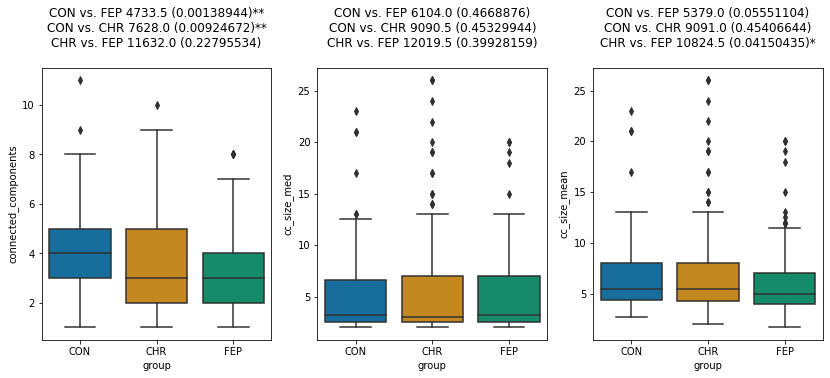

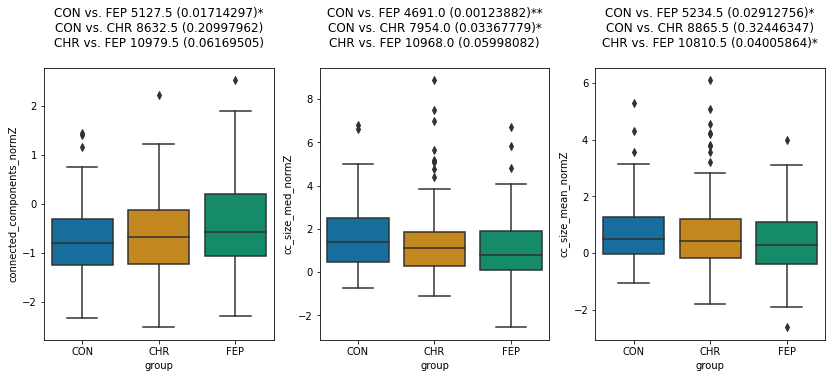

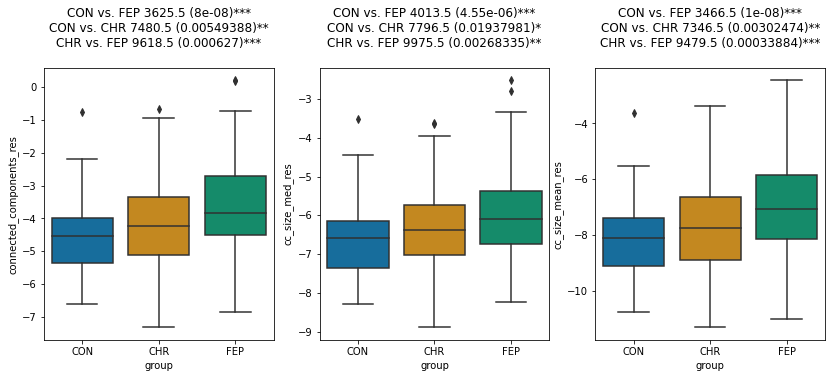

In [51]:
variables = ['connected_components', 'cc_size_med', 'cc_size_mean']



# ------------ Plot the raw connected component values ------------
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(14, 5))
for v,variable in enumerate(variables):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis.query('group == @comb[0]')[variable]
        b = oasis.query('group == @comb[1]')[variable]
        results_mwu.append(sp.stats.mannwhitneyu(a,b))
        results_ttest.append(sp.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures_oasis, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)




# ------------ Plot the residualised connected component values ------------
variable_list = [v + '_normZ' for v in variables]

group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(14, 5))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis.query('group == @comb[0]')[variable]
        b = oasis.query('group == @comb[1]')[variable]
        results_mwu.append(sp.stats.mannwhitneyu(a,b))
        results_ttest.append(sp.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures_oasis, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)


# ------------ Plot the residualised connected component values ------------
variable_list = [v + '_res' for v in variables]

group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(14, 5))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis.query('group == @comb[0]')[variable]
        b = oasis.query('group == @comb[1]')[variable]
        results_mwu.append(sp.stats.mannwhitneyu(a,b))
        results_ttest.append(sp.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures_oasis, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)




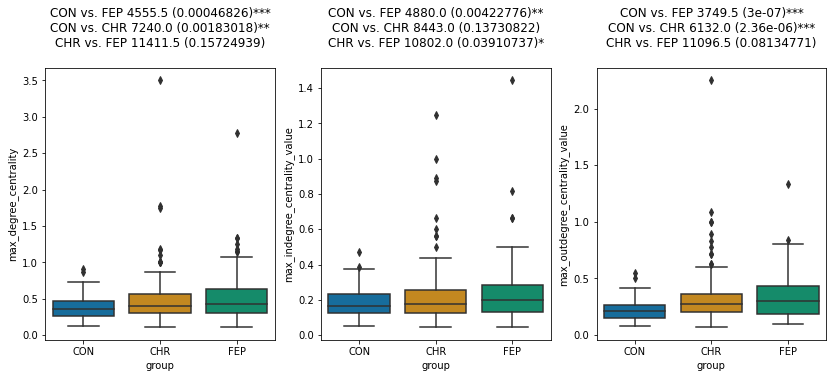

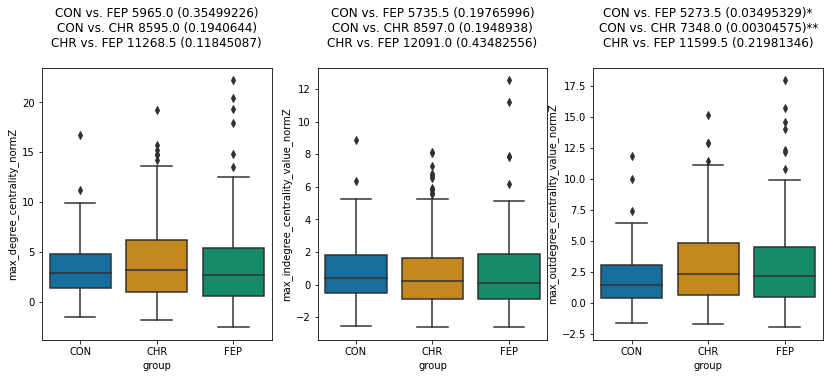

In [50]:
variables = ['max_degree_centrality',
 'max_indegree_centrality_value',
 'max_outdegree_centrality_value']


# ------------ Plot the raw connected component values ------------
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(14, 5))
for v,variable in enumerate(variables):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis.query('group == @comb[0]')[variable]
        b = oasis.query('group == @comb[1]')[variable]
        results_mwu.append(sp.stats.mannwhitneyu(a,b))
        results_ttest.append(sp.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures_oasis, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)




# ------------ Plot the residualised connected component values ------------
variable_list = [v + '_normZ' for v in variables]

group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(14, 5))
for v,variable in enumerate(variable_list):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis.query('group == @comb[0]')[variable]
        b = oasis.query('group == @comb[1]')[variable]
        results_mwu.append(sp.stats.mannwhitneyu(a,b))
        results_ttest.append(sp.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures_oasis, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)


In [55]:
variables = ['nodes', 'edges', 'Coh.']


# ------------ Plot the raw connected component values ------------
group_comparisons = [('CON', 'FEP'), ('CON', 'CHR'), ('CHR', 'FEP')]

fig = plt.figure(figsize=(14, 5))
for v,variable in enumerate(variables):
    ax = plt.subplot(1, 3, v+1)
    sns.boxplot(y=variable, x='group',
              data=oasis,
              palette="colorblind",
              )
    results_mwu = []
    results_ttest = []
    stats_summary = ''
    for c, comb in enumerate(group_comparisons):
        a = oasis.query('group == @comb[0]')[variable]
        b = oasis.query('group == @comb[1]')[variable]
        results_mwu.append(sp.stats.mannwhitneyu(a,b))
        results_ttest.append(sp.stats.ttest_ind(a,b))
        # print('{0} vs. {1} {2} ({3})'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8) ))
        if results_mwu[c][1] < 0.001:
            symbol = '***'
        elif results_mwu[c][1] < 0.01:
            symbol = '**'
        elif results_mwu[c][1] < 0.05:
            symbol = '*'
        else:
            symbol = ''
        stats_summary = stats_summary + '{0} vs. {1} {2} ({3}){4}\n'.format(comb[0], comb[1], round(results_mwu[c][0],8), round(results_mwu[c][1],8), symbol)
    plt.title(stats_summary)
plt.subplots_adjust(hspace = 0.4)
output = op.join(output_figures_oasis, 'Hist_{}' +
                 '_{}'.format('_'.join(variable_list), str(datetime.date.today())))
plt.savefig(output)
plt.show(block=False)


ValueError: Could not interpret input 'Coh.'